# Expert Knowledge Integration with Causal Discovery

Causal Discovery (aka. Structure learning) seeks to uncover the causal relationships among random variables from observational datasets. Methods like the PC algorithm and Hill-climb Search can be used for causal discovery, however, they often struggle to recover the correct causal relationships due to issues such as data not satisfying the assumptions of the method, limited data can lead to error, high compute time when there are many variables or the model is dense.

Incorporating expert knowledge can greatly improve the accuracy of these methods, as well as reduce the computational cost as it constrains the search space for these algorithms. pgmpy currently has the following options to specify expert knowledge:
- **Temporal Order / Tier information**: Specify the tiers/temporal order for sets of variables.
- **Search Space**: Specify the set of edges that the algorithms should search through.
- **Forbidden Edges**: Edges that should not be present in the final model.
- **Required Edges**: Edges that must be present in the final model.

This tutorial walks through examples of specifying expert knowledge with the causal discovery algorithms implemented in pgmpy. Expert knowledge is supported in pgmpy with the following algorithms:

- **PC**
- **Hill Climb Search**
- **GES**
- **ExpertInLoop**

The models used in this notebook are described in detail at [the bnlearn repository](https://www.bnlearn.com/bnrepository/).


## Temporal Order with  PC Algorithm

In [1]:
# Imports and configuration
import logging
import itertools

from IPython.display import display
from pgmpy.utils import get_example_model
from pgmpy.global_vars import logger, config

logger.setLevel(logging.ERROR)
config.set_backend("numpy")

  0%|          | 0/5 [00:00<?, ?it/s]

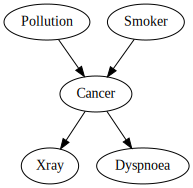

In [2]:
# Load an example model and simulate data from it.
cancer = get_example_model("cancer")
cancer_samples = cancer.simulate(n_samples=5000, seed=42)

# Plot the `cancer` model
diag = cancer.to_graphviz()
diag.layout(prog="dot")
display(diag)

  0%|          | 0/5 [00:00<?, ?it/s]

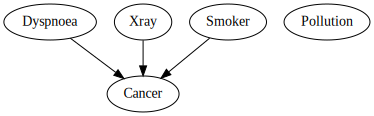

In [3]:
# Run the standard PC algorithm and plot the results

from pgmpy.estimators import PC, ExpertKnowledge

learned_model = PC(cancer_samples).estimate()

diag = learned_model.to_graphviz()
diag.layout(prog="dot")
display(diag)

As seen from the learned model, the PC algorithm was not able to correctly recover the original data-generating DAG. 

Now, we know that smoking (`Smoker`) and air pollution (`Pollution`) contribute to lung cancer (`Cancer`). Also, breathing difficulties (`Dyspnoea`) and a positive X-ray report (`Xray`) contribute to a cancer diagnosis (effect), so they cannot be the initial causes in this scenario. Based on this, we can craft a temporal order where the causes of cancer are at a higher temporal order, while the effects are lumped together at the end.

  0%|          | 0/5 [00:00<?, ?it/s]

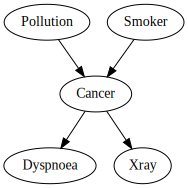

In [4]:
# PC algorithm with the temporal knowledge.

expert_knowledge = ExpertKnowledge(
    temporal_order=[["Pollution", "Smoker"], ["Cancer"], ["Dyspnoea", "Xray"]]
)

est_model = PC(cancer_samples).estimate(expert_knowledge=expert_knowledge)

diag = est_model.to_graphviz()
diag.layout(prog="dot")
display(diag)

Note: Using any form of expert knowledge, especially with PC, is sensitive to the accuracy of the knowledge.

## Expert knowledge based on search space 

  0%|          | 0/8 [00:00<?, ?it/s]

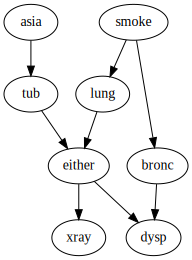

In [5]:
# Load the Asia model and simulate data (https://www.bnlearn.com/bnrepository/discrete-small.html#asia)
asia = get_example_model("asia")
asia_samples = asia.simulate(n_samples=10000, seed=42)

diag = asia.to_graphviz()
diag.layout(prog="dot")
display(diag)

The idea with the search space is that it is usually difficult to distinguish between direct and indirect effects. For example, in the above Asia model, we might know that `smoke` would have a causal effect on `dysp` but might not exactly know through which pathways. With the search space, we try to specify a hypergraph over our variables such that we specify a causal edge between any two variables that we think should have a causal relationship, but aren't sure about the causal path/edges.

As an example, for the `asia` model, we can consider additional edges from all three diseases (`tub`, `lung`, and `bronc`) to both the symptoms (`xray` and `dysp`). 

In [6]:
from pgmpy.metrics import SHD

search_space = [
    ("smoke", "cancer"),
    ("smoke", "lung"),
    ("smoke", "tub"),
    ("tub", "asia"),
    ("asia", "tub"),
    ("tub", "either"),
    ("lung", "either"),
    ("bronc", "either"),
    ("tub", "xray"),
    ("tub", "dysp"),
    ("lung", "x-ray"),
    ("lung", "dysp"),
    ("bronc", "xray"),
    ("bronc", "dysp"),
    ("either", "xray"),
    ("either", "dysp"),
    ("tub", "dysp"),
]

expert_knowledge = ExpertKnowledge(search_space=search_space)

est_model = PC(asia_samples).estimate(expert_knowledge=expert_knowledge, ci_test='pillai', enforce_expert_knowledge=True)
SHD(asia, est_model)

  0%|          | 0/5 [00:00<?, ?it/s]

8

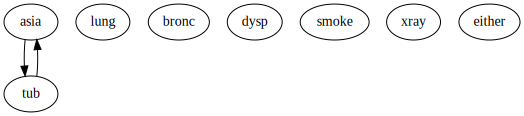

In [7]:
# Plot the estimated model

diag = est_model.to_graphviz()
diag.layout(prog="dot")
display(diag)

## Knowledge base of required and forbidden edges

  0%|          | 0/20 [00:00<?, ?it/s]

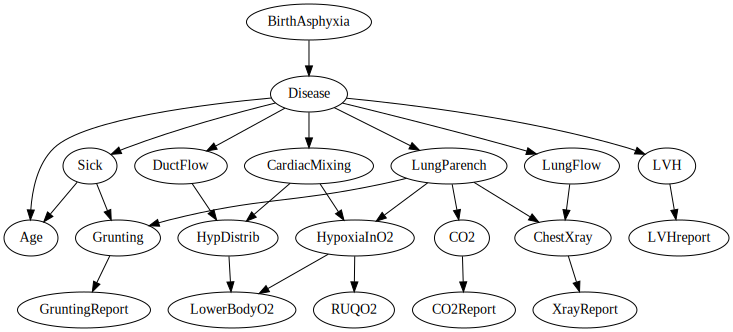

In [8]:
child = get_example_model("child")
child_samples = child.simulate(n_samples=10000, seed=42)

diag = child.to_graphviz()
diag.layout(prog="dot")
display(diag)

Based on similar reasoning as in the first section, we can now create a knowledge base consisting of forbidden and required edges. For example, having birth asphyxia ('Disease') directly contributes to the 6 subclassses/markers of disease ('LVH', 'LungParench' etc.). It is the root cause, so it cannot have incoming edges from any of these nodes. Similarly, the CO2 level ('CO2') affects the CO2 report ('CO2Report'), and not the other way around.

In [9]:
required_edges = [("CO2", "CO2Report"),
                  ("ChestXray", "XrayReport"),
                  ("LVH", "LVHreport"),
                  ("Gruntin", "GruntingReport")]
# As disease should be an exogenous node, do not allow any incoming edges except `BirthAsphyxia'.
forbidden_edges = [(u, v) for u, v in itertools.combinations(child.nodes(), 2) if v == 'Disease']

expert_knowledge = ExpertKnowledge(
    required_edges=required_edges, forbidden_edges=forbidden_edges
)
est_model = PC(child_samples).estimate(expert_knowledge=expert_knowledge, ci_test='pillai', enforce_expert_knowledge=True)
SHD(child, est_model)

  0%|          | 0/5 [00:00<?, ?it/s]

KeyError: frozenset({'Disease', 'CO2'})

In [ ]:
# Plot the estimated model

diag = est_model.to_graphviz()
diag.layout(prog="dot")
display(diag)